In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import AngleData, invert_n

In [2]:
data_path = "data/angle_data_formatted.xlsx"

## Part 1: Calculations from Brewster's angle / Total internal reflection

In [3]:
df = pd.read_excel(data_path, sheet_name = "Part1")
df

,Unnamed: 0,"Eye found Brewster's angle w/ p polarized light, air to dielectric","Eye found Brewster's angle w/ s polarized light, dielectric to air",TIR Angle for p polarized,TIR for S polarized
0,Thick boi,56,34,44,43
1,Turquoise boi,54,34,43,44


In [4]:
def n_from_brewster(angle, air_to_dielectric = True):
    if air_to_dielectric:
        return np.tan(np.deg2rad(angle))
    else:
        return 1 / np.tan(np.deg2rad(angle))

def n_from_tir(angle):
    return 1 / np.sin(np.deg2rad(angle))
    

In [5]:
angle_type = ["Brewster", "Brewster", "TIR", "TIR"]
a2g = [True, False, False, False]  ##Whether each angle corresponds to an air to dielectric change


for index, row in df.iterrows():
    print(f"{row[0]}")
    # Iterating through columns in the current row
    for i, (column_name, angle) in enumerate(row[1:].items()):
        if angle_type[i] == "Brewster":
            n = n_from_brewster(angle, a2g[i])
        else:
            n = n_from_tir(angle)
        print(f"  Using {column_name}, Value: {n}")

Thick boi
  Using Eye found Brewster's angle w/ p polarized light, air to dielectric, Value: 1.4825609685127403
  Using Eye found Brewster's angle w/ s polarized light, dielectric to air, Value: 1.4825609685127403
  Using TIR Angle for p polarized, Value: 1.4395565396257264
  Using TIR for S polarized, Value: 1.466279185639625
Turquoise boi
  Using Eye found Brewster's angle w/ p polarized light, air to dielectric, Value: 1.3763819204711734
  Using Eye found Brewster's angle w/ s polarized light, dielectric to air, Value: 1.4825609685127403
  Using TIR Angle for p polarized, Value: 1.466279185639625
  Using TIR for S polarized, Value: 1.4395565396257264


C:\Users\Jackson\AppData\Local\Temp\ipykernel_14420\2677501452.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{row[0]}")


## Part 2: Snell's law fitting

In [6]:
df = pd.read_excel(data_path, sheet_name = "Part2")
df

,Sample,Interface,90,80,70,60,50,40,30,20,10
0,Turquoise,Air to glass,180,176.0,172.5,168,164.0,160.0,154.5,148.0,140.0
1,Turquoise,Glass to air,180,174.5,169.5,161,145.0,NaN,NaN,NaN,NaN
2,Thick,Air to glass,180,176.5,173.5,170,165.5,161.5,156.0,149.5,142.0
3,Thick,Glass to Air,180,175.0,169.0,163,147.5,NaN,NaN,NaN,NaN


In [7]:
##Parse the data, clean if necessary:
incident_angles = 90 - np.array(df.columns[2:], dtype = np.float64)
angle_data_arr = []

for index, row in df.iterrows():
    sample, interface = row[:2]
    gon_angles = np.array(row[2:], dtype = np.float64)
    if index == 0 or index == 2: #We process air to glass and glass to air interfaces differently
        refr_angles = gon_angles + incident_angles - 180
    else:
        refr_angles = 180 + incident_angles - gon_angles

    angle_data_arr.append(AngleData(sample, 
                                    interface, 
                                    inc_ang = incident_angles,
                                    refr_ang = refr_angles))

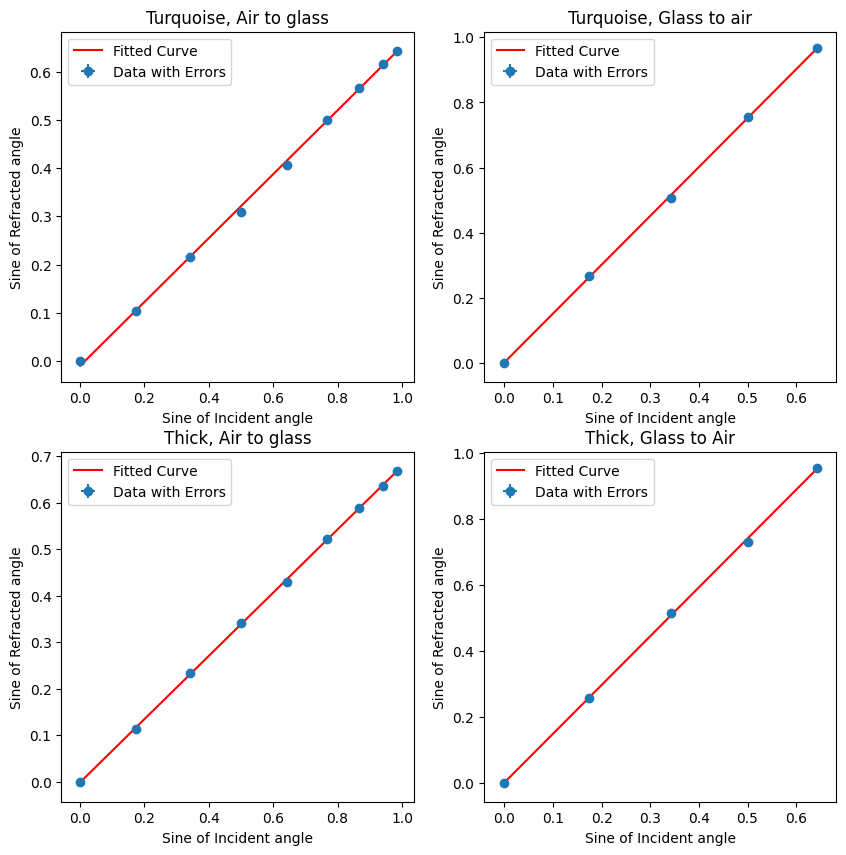

In [8]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
for angle_data, ax in zip(angle_data_arr, axes.flatten()):
    angle_data.plot_snell_fit(ax)

And the indices of refractions extracted:


In [9]:
for i, angle_data in enumerate(angle_data_arr):
    n = angle_data.snell_a
    n_err = angle_data.snell_a_err

    if i == 0 or i == 2: ##air to glass interface
        n, n_err = invert_n(n, n_err)
    
    print(f"IOR from {angle_data.sample}, {angle_data.interface}: {n} +/- {n_err}")

IOR from Turquoise, Air to glass: 1.5118017799564436 +/- 0.018299340820822477
IOR from Turquoise, Glass to air: 1.5009351445335313 +/- 0.010844301143787234
IOR from Thick, Air to glass: 1.4708426484726624 +/- 0.01715054718523621
IOR from Thick, Glass to Air: 1.4809244861303068 +/- 0.011194405070079206


## Part 3: Fresnel Equations w air to glass interface

In [10]:
## Some constants for loss estimation:
THICK_LOSS = 233/281
TURQOUISE_LOSS = 126/281
p3_interface = "Air to glass"


In [11]:
df = pd.read_excel(data_path, sheet_name = "Part3")
df

,Sample,Polarization,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Thick,0.0,90.0,80.0,70.00,60.00,50.00,40.00,30.00,20.000,10.000,NaN,NaN,NaN
1,NaN,NaN,180.0,174.5,172.00,167.50,164.00,160.00,154.00,146.000,137.000,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,42.00,61.50,84.00,103.50,123.00,144.000,164.000,NaN,NaN,NaN
3,NaN,NaN,570.0,574.0,571.00,568.00,551.00,528.00,473.00,394.000,237.000,NaN,NaN,NaN
4,NaN,NaN,0.0,0.0,26.90,34.00,49.30,71.50,117.00,207.000,364.000,NaN,NaN,NaN
5,Turquoise,0.0,90.0,80.0,70.00,60.00,50.00,40.00,30.00,20.000,10.000,NaN,NaN,NaN
6,NaN,NaN,180.0,176.0,173.00,169.00,165.00,161.00,154.00,147.000,141.500,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,41.00,61.00,79.00,100.00,120.00,141.000,160.000,NaN,NaN,NaN
8,NaN,NaN,278.0,280.0,279.00,277.00,260.00,249.00,230.00,185.000,7.500,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,28.30,34.40,36.90,60.50,91.50,152.000,260.000,NaN,NaN,NaN


In [12]:
##Data cleaning / processing
angle_data_arr = []
step_size = 5
for i in range(0, len(df), step_size):
    sample = df.iloc[i, 0]

    loss_correction = 1/THICK_LOSS if sample == "Thick" else 1/TURQOUISE_LOSS
    
    incident_angles = 90 - np.array(df.iloc[i, 2:], dtype = np.float64)
    gon_angles = np.array(df.iloc[i + 1, 2:], dtype = np.float64)
    transmitted_angles = gon_angles + incident_angles - 180

    trans_int = np.array(df.iloc[i + 3, 2:], dtype = np.float64) * loss_correction
    refl_int = np.array(df.iloc[i + 4, 2:], dtype = np.float64)

    angle_data = AngleData(sample, 
                           interface = p3_interface, 
                           inc_ang = incident_angles, 
                           refr_ang = transmitted_angles,
                           trans_int = trans_int, 
                           refl_int = refl_int, 
                           p_polarized = df.iloc[i, 1] == 90)
    angle_data_arr.append(angle_data)
    

c:\Users\Jackson\physics_387\boundary\utils.py:79: RuntimeWarning: invalid value encountered in arcsin
  trans_ang = np.arcsin(np.sin(inc_ang) / p)


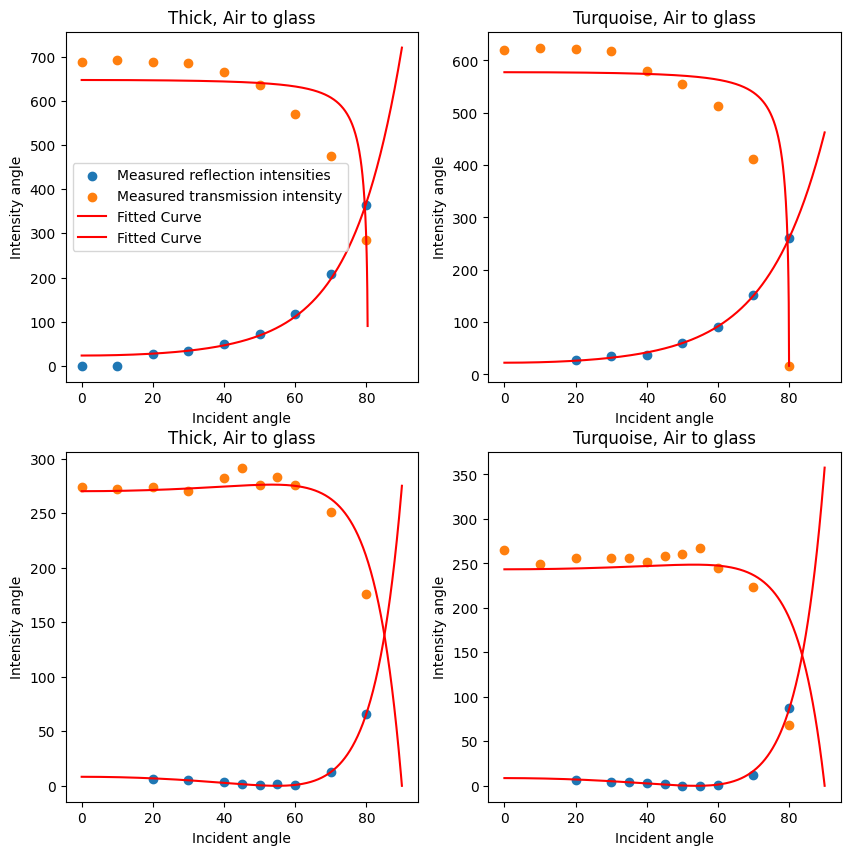

In [13]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
for i, ax in enumerate(axes.flatten()):
    angle_data_arr[i].plot_fresnel_fit(ax)

axes[0, 0].legend()

## Part 4: Fresnel equations with glass to air

In [14]:
## Some constants for loss estimation:
p4_interface = "Glass to air"
df = pd.read_excel(data_path, sheet_name = "Part4")
df


,Sample,Polarization,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Thick,0.0,90.0,80.0,70.00,60.000,55.000,50.00,45.000,NaN
1,NaN,NaN,180.0,174.0,170.00,162.000,155.000,144.00,153.500,NaN
2,NaN,NaN,NaN,NaN,40.00,60.500,70.000,81.00,90.000,NaN
3,NaN,NaN,139.0,135.0,132.00,129.000,116.000,68.00,0.335,NaN
4,NaN,NaN,NaN,NaN,5.30,10.500,18.600,43.80,122.000,NaN
5,Turquoise,0.0,90.0,80.0,70.00,60.000,55.000,50.00,45.000,NaN
6,NaN,NaN,180.0,176.0,170.00,162.500,157.000,145.00,150.000,NaN
7,NaN,NaN,NaN,NaN,39.00,58.000,68.000,79.00,89.000,NaN
8,NaN,NaN,73.0,72.0,66.00,64.000,62.500,39.00,0.131,NaN
9,NaN,NaN,NaN,NaN,1.97,3.400,5.490,13.30,30.300,NaN


In [15]:
##Data cleaning / processing
angle_data_arr = []
step_size = 5
for i in range(0, len(df), step_size):
    sample = df.iloc[i, 0]

    loss_correction = 1/THICK_LOSS if sample == "Thick" else 1/TURQOUISE_LOSS
    
    incident_angles = 90 - np.array(df.iloc[i, 2:], dtype = np.float64)
    gon_angles = np.array(df.iloc[i + 1, 2:], dtype = np.float64)
    transmitted_angles = gon_angles + incident_angles - 180

    trans_int = np.array(df.iloc[i + 3, 2:], dtype = np.float64)
    refl_int = np.array(df.iloc[i + 4, 2:], dtype = np.float64) * loss_correction

    angle_data = AngleData(sample, 
                           interface = p3_interface, 
                           inc_ang = incident_angles, 
                           refr_ang = transmitted_angles,
                           trans_int = trans_int, 
                           refl_int = refl_int, 
                           p_polarized = df.iloc[i, 1] == 90)
    angle_data_arr.append(angle_data)
    

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

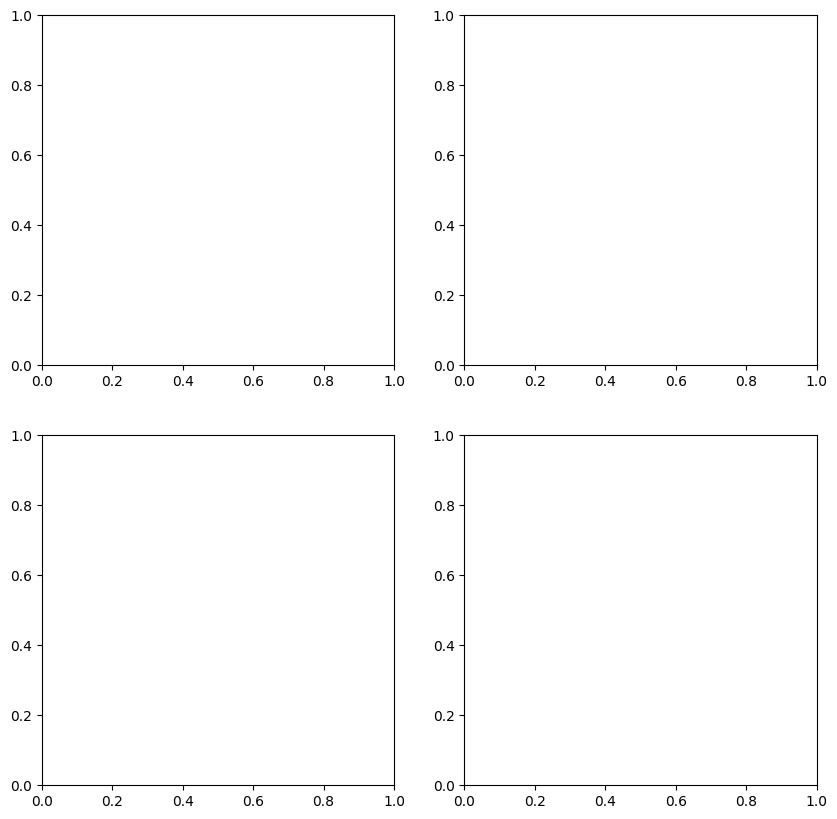

In [16]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
for i, ax in enumerate(axes.flatten()):
    angle_data_arr[i].plot_fresnel_fit(ax)

axes[0, 0].legend()